# ML - Based Bioactivity Predictor Model
1. bioactivity data was downloaded from ChEMBL database
** To build this model we require:
--> Chemical structures
--> bioactivity values 
--> cut-off ranges(to make categories)


In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [416]:
# Loading data set and making a copy of it
df = pd.read_csv('brd4_bioactivity_data.csv', sep=";")
df_copy = df.copy() 

In [417]:
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL1957266,NaN,0,457.00,1,5.53,"2, (+)-JQ1",Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,'=',...,Bromodomain-containing protein 4,Homo sapiens,SINGLE PROTEIN,CHEMBL2150870,1,Scientific Literature,ACS Med. Chem. Lett.,2012,None,NaN
1,CHEMBL3897393,NaN,0,424.48,0,3.03,1; GNE-272,CC(=O)N1CCc2c(c(Nc3ccc(-c4cnn(C)c4)cc3F)nn2[C@...,IC50,'=',...,Bromodomain-containing protein 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4052814,1,Scientific Literature,J Med Chem,2017,None,NaN
2,CHEMBL1957266,NaN,0,457.00,1,5.53,(+)-JQ1,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,Kd,'=',...,Bromodomain-containing protein 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1955852,1,Scientific Literature,Bioorg. Med. Chem.,2012,None,NaN
3,CHEMBL1957266,NaN,0,457.00,1,5.53,(+)-JQ1,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,'=',...,Bromodomain-containing protein 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1955852,1,Scientific Literature,Bioorg. Med. Chem.,2012,None,NaN
4,CHEMBL3581653,NaN,0,326.79,0,4.39,10,COc1cc2c(cc1-c1c(C)n[nH]c1C)[nH]c1ccnc(Cl)c12,Ki,'=',...,Bromodomain-containing protein 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3580597,1,Scientific Literature,J. Med. Chem.,2015,None,NaN


In [418]:
df.shape

(9723, 45)

In [419]:
df.columns

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')

# Data Cleaning and Eploratory Data Analysis 

In [420]:
# Selecting columns of interest for bioactivity prediction 
df_interest = df[['Molecule ChEMBL ID','Smiles', 'Standard Type','Standard Value','Standard Units']]

In [421]:
df_interest.shape

(9723, 5)

In [422]:
# checking for null or missing values in rows
df_interest.isnull().sum()

Molecule ChEMBL ID      0
Smiles                  1
Standard Type           0
Standard Value        731
Standard Units        434
dtype: int64

In [423]:
# choose to drop all rows with missing values. Note these can also be populated by mean valeus if neccessary 
df_interest.dropna(inplace=True)

C:\Users\jconteh\Anaconda3\envs\uresearcher\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [424]:
df_interest.shape

(8877, 5)

In [425]:
# Multiple Standard units present in data 
df_interest['Standard Units'].unique()

array(['nM', 'degrees C', '%', 'uM', 'Da', 'K', 'C', '10^2 uM', 'µM',
       'kcal/mol'], dtype=object)

In [426]:
#filtering out standard Units that are not nM
df1 = df_interest[df_interest['Standard Units'].str.contains('nM')]

In [427]:
df1['Standard Units'].unique()

array(['nM'], dtype=object)

In [428]:
# Multiple Standard Types present in data 
df1['Standard Type'].unique()

array(['IC50', 'Kd', 'Ki', 'EC50', 'K', 'DC50', 'Activity'], dtype=object)

In [435]:
#filtering out standard types that are not IC50 vales
df1 = df1[df1['Standard Type'].str.contains('IC50')]

In [436]:
df1.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
0,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,77.00,nM
1,CHEMBL3897393,CC(=O)N1CCc2c(c(Nc3ccc(-c4cnn(C)c4)cc3F)nn2[C@...,IC50,13000.00,nM
3,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,77.00,nM
12,CHEMBL2017264,Cc1noc(C)c1-c1ccc2c(Nc3ccccc3F)c(C(N)=O)cnc2c1,IC50,7943.28,nM
13,CHEMBL2017291,COc1cc2c(cc1-c1c(C)noc1C)ncc1[nH]c(=O)n([C@H](...,IC50,25.12,nM


In [437]:
df1.shape

(5003, 5)

In [438]:
# Checking for duplicate structures in the data frame. Yes we have duplicates
df1['Molecule ChEMBL ID'].value_counts()


CHEMBL1957266    91
CHEMBL1232461    33
CHEMBL2393130    25
CHEMBL2017291    22
CHEMBL3581647    16
                 ..
CHEMBL3910167     1
CHEMBL3931840     1
CHEMBL4095353     1
CHEMBL4071581     1
CHEMBL4069412     1
Name: Molecule ChEMBL ID, Length: 3518, dtype: int64

In [439]:
# Exploring the data set for duplicates having Molecule ChEMBL ID equals 'CHEMBL1957266'
x = df1[df1['Molecule ChEMBL ID'].str.contains('CHEMBL1957266')].sort_values('Standard Value', ascending=False)
x.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units
7281,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,81500.0,nM
4624,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,1630.0,nM
3113,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,1510.0,nM
4325,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,1490.0,nM
3677,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,1380.0,nM


### To remove all the duplicates from the data frame:
1. Group the molecules in terms of Molecule ID, 
2. generate their mean values and 
3. remove all the duplicate values from the data frame 

In [440]:
df1['Avg_Standard_Value'] = df1.groupby(['Molecule ChEMBL ID'])['Standard Value'].transform ("mean")

In [441]:
df1.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,Avg_Standard_Value
0,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,77.00,nM,1061.082857
1,CHEMBL3897393,CC(=O)N1CCc2c(c(Nc3ccc(-c4cnn(C)c4)cc3F)nn2[C@...,IC50,13000.00,nM,13000.000000
3,CHEMBL1957266,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,IC50,77.00,nM,1061.082857
12,CHEMBL2017264,Cc1noc(C)c1-c1ccc2c(Nc3ccccc3F)c(C(N)=O)cnc2c1,IC50,7943.28,nM,7943.280000
13,CHEMBL2017291,COc1cc2c(cc1-c1c(C)noc1C)ncc1[nH]c(=O)n([C@H](...,IC50,25.12,nM,317.984545


In [442]:
df1 = df1.sort_values('Avg_Standard_Value', ascending=True)
df1.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,Avg_Standard_Value
3297,CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,IC50,0.43,nM,0.43
3314,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,IC50,0.50,nM,0.50
6023,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,IC50,0.70,nM,0.70
6377,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,IC50,0.60,nM,0.75
6177,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,IC50,0.90,nM,0.75


In [443]:
#Duplicates still present
df1.shape

(5003, 6)

In [444]:
#duplicates removed
df1 = df1.drop_duplicates('Molecule ChEMBL ID', keep='first' )
df1.shape

(3518, 6)

In [445]:
df1.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,Avg_Standard_Value
3297,CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,IC50,0.43,nM,0.43
3314,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,IC50,0.50,nM,0.50
6023,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,IC50,0.70,nM,0.70
6377,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,IC50,0.60,nM,0.75
3318,CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,IC50,0.93,nM,0.93


In [480]:
# dropping the old standard value column
df2 = df1.drop ('Standard Value', axis=1)
df2.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Units,Avg_Standard_Value
3297,CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,IC50,nM,0.43
3314,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,IC50,nM,0.50
6023,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,IC50,nM,0.70
6377,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,IC50,nM,0.75
3318,CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,IC50,nM,0.93


In [481]:
df2.shape

(3518, 5)

## Categorization of standard values as either actives and inactives

In [482]:
# Creating a new label column, apply lamda function to transform the average standard values into actives = 1 and inactives = 0
df2['bioactivity_label'] = df2['Avg_Standard_Value'].apply(lambda x: 1 if x<=500 else 0)

In [483]:
# Set the 'Molecule ChEMBL ID' varible as DF index before using the loc function
                            
df2.set_index('Molecule ChEMBL ID', inplace=True)     

In [557]:
df2.head()

,Smiles,Standard Type,Standard Units,Avg_Standard_Value,bioactivity_label
Molecule ChEMBL ID,,,,,
CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,IC50,nM,0.43,1
CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,IC50,nM,0.50,1
CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,IC50,nM,0.70,1
CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,IC50,nM,0.75,1
CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,IC50,nM,0.93,1


In [489]:
df2['bioactivity_label'].unique()

array([1, 0], dtype=int64)

In [490]:
df2.shape

(3518, 5)

In [504]:
# saving the cleaned dataframe as csv file for future use 
df2.to_csv('labelled_brd4_bioactivity_data.csv')

In [558]:
final_df = df2[['Smiles', 'bioactivity_label', 'Avg_Standard_Value']]
final_df

,Smiles,bioactivity_label,Avg_Standard_Value
Molecule ChEMBL ID,,,
CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,1,4.300000e-01
CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,1,5.000000e-01
CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,1,7.000000e-01
CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,1,7.500000e-01
CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,1,9.300000e-01
...,...,...,...
CHEMBL4800198,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(CCCc2cc...,0,5.000000e+06
CHEMBL4448567,COC(=O)C1CC(=O)N(C)C1,0,6.880000e+06
CHEMBL3134571,CNC(=O)[C@H](CCCCNC(C)=O)NC,0,7.000000e+06


In [559]:
# save final brd4 data for model building 
final_df.to_csv('final_brd4_bioactivity_data.csv',sep=";", index=True, header=True)

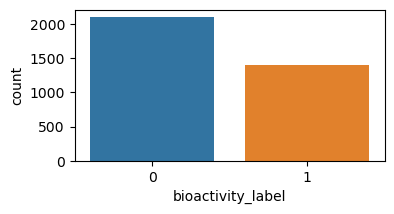

In [560]:
#Visualizing the label counts   
plt.figure(figsize=(4,2),dpi=100)
sns.countplot(x='bioactivity_label',data=final_df);

# EXPLORATORY DATA ANALYSIS

In [561]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [562]:
df3 = pd.read_csv('final_brd4_bioactivity_data.csv', sep=";")
df3

,Molecule ChEMBL ID,Smiles,bioactivity_label,Avg_Standard_Value
0,CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,1,4.300000e-01
1,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,1,5.000000e-01
2,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,1,7.000000e-01
3,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,1,7.500000e-01
4,CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,1,9.300000e-01
...,...,...,...,...
3513,CHEMBL4800198,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(CCCc2cc...,0,5.000000e+06
3514,CHEMBL4448567,COC(=O)C1CC(=O)N(C)C1,0,6.880000e+06
3515,CHEMBL3134571,CNC(=O)[C@H](CCCCNC(C)=O)NC,0,7.000000e+06
3516,CHEMBL3220211,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@H](CC(=O)OC(C)...,0,1.341235e+07


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

In [563]:
# lipinski function creation
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [564]:
#function calling and calculating the lipinski parameters 
df_lipinski = lipinski(df3.Smiles)

In [565]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,501.052000,5.28556,1.0,8.0
1,451.473000,3.75740,1.0,5.0
2,456.474000,3.40310,1.0,6.0
3,535.613305,5.21002,1.0,8.0
4,473.978000,5.00670,0.0,6.0
...,...,...,...,...
3513,428.598000,3.83810,0.0,3.0
3514,157.169000,-0.36230,0.0,3.0
3515,215.297000,-0.37320,3.0,3.0
3516,456.999000,5.53136,0.0,7.0


## Combining the lipinski and the bioactivity data frame 

In [566]:

df_combined = pd.concat([df3,df_lipinski], axis=1)

In [567]:
df_combined

,Molecule ChEMBL ID,Smiles,bioactivity_label,Avg_Standard_Value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL4077038,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OCCC...,1,4.300000e-01,501.052000,5.28556,1.0,8.0
1,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,1,5.000000e-01,451.473000,3.75740,1.0,5.0
2,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,1,7.000000e-01,456.474000,3.40310,1.0,6.0
3,CHEMBL4846895,[2H]C([2H])([2H])c1nnn(C)c1-c1cnc2c3ccc(C(C)(C...,1,7.500000e-01,535.613305,5.21002,1.0,8.0
4,CHEMBL4075567,CCS(=O)(=O)c1ccc2c(c1)-c1cn(C)c(=O)cc1OCCCCc1c...,1,9.300000e-01,473.978000,5.00670,0.0,6.0
...,...,...,...,...,...,...,...,...
3513,CHEMBL4800198,CCN(CC)S(=O)(=O)c1ccc(C2CC(=O)N(C)C2)c(CCCc2cc...,0,5.000000e+06,428.598000,3.83810,0.0,3.0
3514,CHEMBL4448567,COC(=O)C1CC(=O)N(C)C1,0,6.880000e+06,157.169000,-0.36230,0.0,3.0
3515,CHEMBL3134571,CNC(=O)[C@H](CCCCNC(C)=O)NC,0,7.000000e+06,215.297000,-0.37320,3.0,3.0
3516,CHEMBL3220211,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@H](CC(=O)OC(C)...,0,1.341235e+07,456.999000,5.53136,0.0,7.0


# Extracting Candidate molecules for Docking study
### Fetching out bioactive molecules with drug-likness that could be used for molecular docking excercise  

In [580]:
df_drug_like = df_combined[(df_combined['bioactivity_label']==1) & (df_combined['Avg_Standard_Value']<=50)&(df_combined['MW'] <=500) & (df_combined['LogP']<=4) & (df_combined['NumHDonors']<=5)&(df_combined['NumHAcceptors']<=10)] 

In [581]:
df_drug_like

,Molecule ChEMBL ID,Smiles,bioactivity_label,Avg_Standard_Value,MW,LogP,NumHDonors,NumHAcceptors
1,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,1,0.5,451.473,3.75740,1.0,5.0
2,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,1,0.7,456.474,3.40310,1.0,6.0
10,CHEMBL3786682,Cn1cc2c3c(c[nH]c(=O)c31)CN(c1ccccn1)c1ccc(CS(C...,1,1.4,420.494,3.12490,1.0,6.0
12,CHEMBL4212498,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccc(F)cc1)c1ccc(CS(...,1,1.5,437.496,3.86900,1.0,5.0
16,CHEMBL4208129,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccccn1)c1ccc(CS(C)(...,1,1.7,420.494,3.12490,1.0,6.0
...,...,...,...,...,...,...,...,...
527,CHEMBL3978169,Cc1noc(C)c1-c1ccc2c(c1)C(NCCO)(c1ccsc1)C(=O)N2,1,49.0,369.446,2.79754,3.0,6.0
528,CHEMBL3905296,Cc1nc(-c2nc3cnc(N4CCOCC4)cc3n2Cc2ccccc2)cn(C)c1=O,1,49.0,416.485,2.38532,0.0,8.0
532,CHEMBL3910821,Cc1cc(-c2nc3cnc(N4CCOC[C@@H]4C)cc3n2C(C)CC2CC2...,1,50.0,421.545,3.69162,0.0,7.0
533,CHEMBL3972267,Cc1cc(-c2nc3cnc(N4CCOCC4)nc3n2Cc2ccccc2)cn(C)c1=O,1,50.0,416.485,2.38532,0.0,8.0


In [582]:
#checking molecules with '0' NumHDonors
df_no_NumHDonors = df_drug_like[(df_drug_like['NumHDonors'] ==0)|(df_drug_like['NumHAcceptors'] ==0)]
df_no_NumHDonors

,Molecule ChEMBL ID,Smiles,bioactivity_label,Avg_Standard_Value,MW,LogP,NumHDonors,NumHAcceptors
17,CHEMBL4593553,COc1nnc2ccc(N3CCC(c4ccc(OCCN5CCN(C)C(=O)C5C)cc...,1,1.7,479.585,2.05820,0.0,9.0
94,CHEMBL4578490,Cc1ccc(-n2c(C)nnc2-c2ccc3c(c2)N(C2CC2)C(C)C(=O...,1,5.7,387.487,3.88484,0.0,5.0
110,CHEMBL4227387,CCCOc1ccc(S(C)(=O)=O)cc1-c1cn(C)c(=O)c2ccc(-c3...,1,7.0,451.548,3.79830,0.0,7.0
125,CHEMBL4585487,Cc1ccc(-n2cnnc2-c2ccc3c(c2)N(C2CC2)C(C)C(=O)N3...,1,8.6,373.460,3.57642,0.0,5.0
140,CHEMBL4556261,Cc1ccc(-n2nc(C(=O)N3CCN(C)CC3)nc2-c2ccc3c(c2)N...,1,9.4,499.619,2.96402,0.0,7.0
...,...,...,...,...,...,...,...,...
523,CHEMBL3959228,CCn1cc(-c2nc3ccc(N4CCN(C)CC4)cc3n2Cc2ccccc2)cc...,1,49.0,441.579,3.99342,0.0,6.0
528,CHEMBL3905296,Cc1nc(-c2nc3cnc(N4CCOCC4)cc3n2Cc2ccccc2)cn(C)c1=O,1,49.0,416.485,2.38532,0.0,8.0
532,CHEMBL3910821,Cc1cc(-c2nc3cnc(N4CCOC[C@@H]4C)cc3n2C(C)CC2CC2...,1,50.0,421.545,3.69162,0.0,7.0
533,CHEMBL3972267,Cc1cc(-c2nc3cnc(N4CCOCC4)nc3n2Cc2ccccc2)cn(C)c1=O,1,50.0,416.485,2.38532,0.0,8.0


In [583]:
# drop molecules with zero NumHDonors and NumHAcceptors
df_true_drug_like = df_drug_like.drop(df_no_NumHDonors.index, axis=0) # Step 2
df_true_drug_like   # candidates for docking study

,Molecule ChEMBL ID,Smiles,bioactivity_label,Avg_Standard_Value,MW,LogP,NumHDonors,NumHAcceptors
1,CHEMBL4068487,CCNC(=O)CC1N=C(c2c(F)cccc2F)c2cc(OC)ccc2-c2cn(...,1,0.5,451.473,3.75740,1.0,5.0
2,CHEMBL3785440,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ncc(F)cc1F)c1ccc(CS...,1,0.7,456.474,3.40310,1.0,6.0
10,CHEMBL3786682,Cn1cc2c3c(c[nH]c(=O)c31)CN(c1ccccn1)c1ccc(CS(C...,1,1.4,420.494,3.12490,1.0,6.0
12,CHEMBL4212498,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccc(F)cc1)c1ccc(CS(...,1,1.5,437.496,3.86900,1.0,5.0
16,CHEMBL4208129,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccccn1)c1ccc(CS(C)(...,1,1.7,420.494,3.12490,1.0,6.0
...,...,...,...,...,...,...,...,...
509,CHEMBL4202403,Cc1ccc(NC(=O)c2ccc3c(c2)N(C2CC2)C(C)C(=O)N3C)cc1,1,46.4,349.434,3.58102,1.0,3.0
513,CHEMBL4466613,COc1cc(C(=O)N2CCC(O)CC2)ccc1Nc1ccc2c(n1)N(C1CC...,1,47.0,493.608,3.54460,2.0,7.0
518,CHEMBL4208643,COC(=O)N1Cc2cn(C)c3c(=O)[nH]cc(c23)-c2cc(CS(C)...,1,48.0,401.444,2.16460,1.0,6.0
520,CHEMBL4449279,Cc1cc(-c2cc(NS(C)(=O)=O)ccc2Nc2ccccc2)n2cc[nH]...,1,48.2,408.483,3.71812,3.0,5.0
